In [23]:
## Import necessary libraries
import glob
import os
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score

In [27]:
## Accessing data

# Mount Google Drive
drive.mount('/content/drive', force_remount = True)

# Downloading the dataset
path = '/content/data'
gdown.download_folder('https://drive.google.com/drive/folders/1ha7P4Mwp6_XYnUHs20460CbBC4zwNvf9', output = path, quiet=True)

Mounted at /content/drive


['/content/data/sesion_01_20/sensor01_air.txt',
 '/content/data/sesion_01_20/sensor01_izopropanol.txt',
 '/content/data/sesion_01_20/sensor01_water.txt',
 '/content/data/sesion_02_20/sensor02_air.txt',
 '/content/data/sesion_02_20/sensor02_izopropanol.txt',
 '/content/data/sesion_02_20/sensor02_water.txt',
 '/content/data/sesion_03_20/sensor03_air.txt',
 '/content/data/sesion_03_20/sensor03_izopropanol.txt',
 '/content/data/sesion_03_20/sensor03_water.txt',
 '/content/data/sesion_04_20/sensor04_air.txt',
 '/content/data/sesion_04_20/sensor04_izopropanol.txt',
 '/content/data/sesion_04_20/sensor04_water.txt',
 '/content/data/sesion_05_20/sensor05_air.txt',
 '/content/data/sesion_05_20/sensor05_izopropanol.txt',
 '/content/data/sesion_05_20/sensor05_water.txt',
 '/content/data/sesion_06_20/sensor06_air.txt',
 '/content/data/sesion_06_20/sensor06_izopropanol.txt',
 '/content/data/sesion_06_20/sensor06_water.txt',
 '/content/data/sesion_07_20/sensor07_air.txt',
 '/content/data/sesion_07_20

In [28]:
## Data loading into pandas dataframe 'df'

# Get a list of all the files in the subfolders

files = glob.glob(path + '/**/*.txt', recursive=True)

# Create an empty list to store the dataframes
dfs = []

# Load all files from folders and concatenate the resulting dataframe into one
for file in files:
    df = pd.read_csv(file, sep=',',header=None, names=['wavelength', 'amplitude'])

    # Add a column with the sensor number and sensor medium
    file_name = file.split('/')[-1]
    file_name = file_name.replace('.txt','')
    df['sensor_number'] = int(file_name.split('_')[-2][-2:])
    df['sensor_medium'] = file_name.split('_')[-1]
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

new_air_data = df[(df['sensor_medium'] == 'air') & (df['sensor_number'] == 6)][['wavelength', 'amplitude']]

In [30]:
# Extracting the unique values for medium of measurement
sensor_mediums = df['sensor_medium'].unique()

# Extracting the unique values for sensor number
sensor_numbers = df['sensor_number'].unique()

# Specify the directory that the files have to be saved in
directory = path + '/figures_actual'


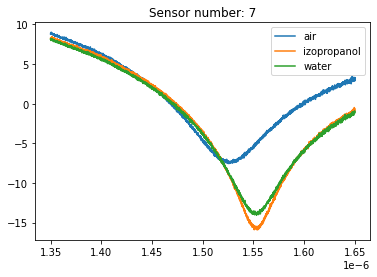

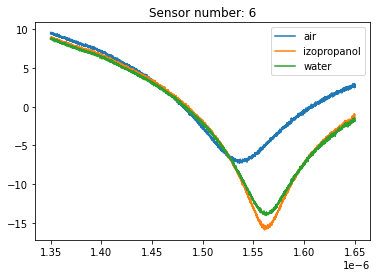

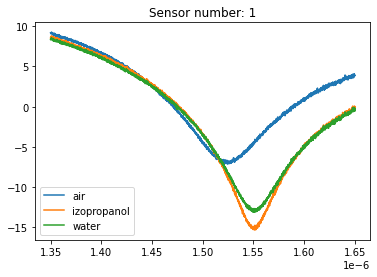

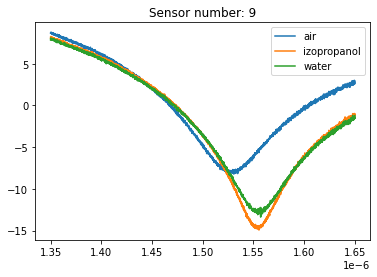

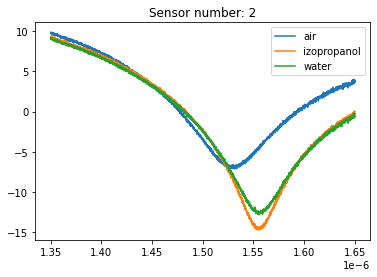

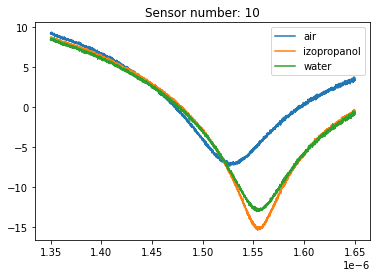

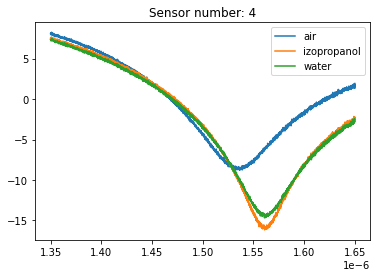

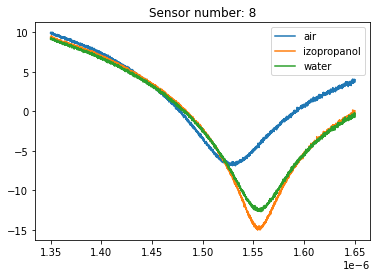

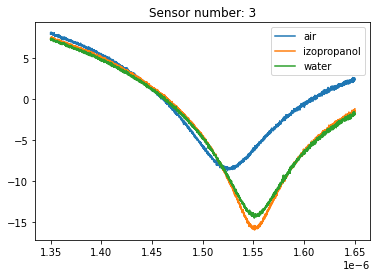

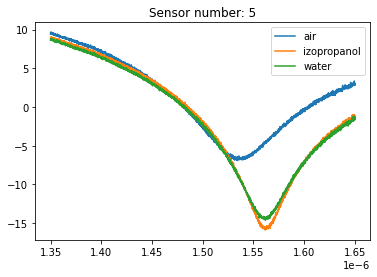

In [31]:
## Graph of data for each sensor(izo, water, air) 

# Looping over each unique sensor number
for sensor in sensor_numbers:
    
    # Extracting data for the current sensor
    sensor_df = df[df['sensor_number'] == sensor]
    
    # Plotting a separate graph for each medium of measurement
    for medium in sensor_mediums:
        
        # Extracting data for the current medium
        medium_df = sensor_df[sensor_df['sensor_medium'] == medium]
        
        # Plotting the current medium
        plt.plot(medium_df['wavelength'], medium_df['amplitude'], label=medium)

        # Make a new directory if the directory doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        # Generate the file name for the current sensor
        filename = 'Sensor number_{}.png'.format(sensor)
        filepath = os.path.join(directory, filename)
        
        # Check if the file already exists
        if os.path.exists(filepath):
            # Remove the file if it exists
            os.remove(filepath)
        # Get current figure
        plt.gcf()

        # Save figure
        plt.savefig(filepath, bbox_inches='tight', dpi= 100)
    
    # Setting the title of the graph based on the current sensor number
    plt.title('Sensor number: {}'.format(sensor))
    
    # Adding a legend to the graph
    plt.legend()
    
    # Showing the graph
    plt.show()

{'alpha': 0.0001, 'average': True, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': 43, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'alpha': 0.0001, 'average': True, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': 43, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}


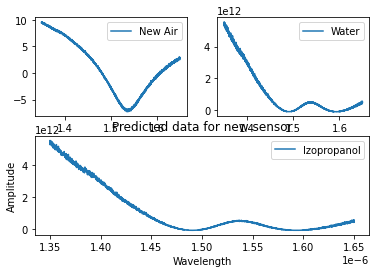

In [45]:
##Model

poly_features = []
model_water = []
model_izo = []

# Filter data for air readings
air_data = df[df['sensor_medium'] == 'air']

for sensor_number in sensor_numbers:
  # Generate 3rd degree polynomial features for air data
  poly_features = PolynomialFeatures(degree=3, include_bias=False)
  air_data_poly = poly_features.fit_transform(air_data[air_data['sensor_number'] == sensor_number][['wavelength', 'amplitude']])

  # Define parameters
  y_scaling_factor = 4

  params = { 
    'penalty': 'l2', 
    'alpha': 0.0001, 
    'max_iter': 1000, 
    'tol': 1e-3, 
    'random_state': 43,
    'warm_start': True,
    'average': True
  } 

  # Train separate models for water and izopropanol outputs based on air data and scale y-s for data coverage
  water_pred = df[(df['sensor_medium'] == 'water') & (df['sensor_number'] == sensor_number)]['wavelength']
  water_pred_scaled = water_pred * y_scaling_factor
  model_water = SGDRegressor(**params)
  model_water.partial_fit(air_data_poly, water_pred_scaled)

  izo_pred = df[(df['sensor_medium'] == 'izopropanol') & (df['sensor_number'] == sensor_number)]['wavelength']
  izo_pred_scaled = izo_pred * y_scaling_factor
  model_izo = SGDRegressor(**params)
  model_izo.partial_fit(air_data_poly, izo_pred_scaled)

# Predict outputs for water and izopropanol based on some new air data
new_air_data = df[(df['sensor_medium'] == 'air') & (df['sensor_number'] == 6)][['wavelength', 'amplitude']]
new_air_data_poly = poly_features.transform(new_air_data[['wavelength', 'amplitude']])
pred_water = model_water.predict(new_air_data_poly)
pred_izo = model_izo.predict(new_air_data_poly)

# Print model parameters

print(model_izo.get_params(deep=True))
print(model_water.get_params(deep=True))

# Plot predicted outputs for water and izopropanol against new air data among grid data
fig = plt.figure()
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=2)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=2)

ax1.plot(new_air_data['wavelength'], new_air_data['amplitude'], label = 'New Air')
ax2.plot(new_air_data['wavelength'], pred_water, label='Water')
ax3.plot(new_air_data['wavelength'], pred_izo, label='Izopropanol')

plt.title('Predicted data for new sensor')
plt.xlabel('Wavelength')
plt.ylabel('Amplitude')
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Reset the models
model_water = SGDRegressor(max_iter=1000, tol=1e-3)
model_izo = SGDRegressor(max_iter=1000, tol=1e-3)

# Set up an output file
pred_data_water = np.column_stack((new_air_data['wavelength'].values, pred_water))
pred_data_izo = np.column_stack((new_air_data['wavelength'].values, pred_izo))

# Save in directory if it exists and if not then create a directory
next_sensor = len(sensor_numbers) + 1
saved_data_path = '/content/data/predicted_sensor'
if not os.path.exists(saved_data_path):
  os.mkdir(saved_data_path)
np.savetxt(saved_data_path + '/predicted_output_water_sensor' + str(next_sensor) + '.txt', pred_data_water, delimiter=',', header='wavelength,amplitude')
np.savetxt(saved_data_path + '/predicted_output_izo_sensor' + str(next_sensor) + '.txt', pred_data_izo, delimiter=',', header='wavelength,amplitude')

In [47]:
## R^2 Score for random sensor from actual data

# Get actual water and izopropanol data for comparison
actual_water = df[(df['sensor_medium'] == 'water') & (df['sensor_number'] == random.randrange(len(sensor_numbers)))]['wavelength']
actual_izo = df[(df['sensor_medium'] == 'izopropanol') & (df['sensor_number'] == random.randrange(len(sensor_numbers)))]['wavelength']

# Calculate R^2 score for predicted water data
r2_score_water = r2_score(actual_water, pred_water)
print('R^2 score for predicted water data: ', r2_score_water)

# Calculate R^2 score for predicted izopropanol data
r2_score_izo = r2_score(actual_izo, pred_izo)
print('R^2 score for predicted izopropanol data: ', r2_score_izo)


R^2 score for predicted water data:  -4.7734831405116605e+38
R^2 score for predicted izopropanol data:  -4.7734831405116605e+38
